In [ ]:
import xarray as xr

def grid_mapping(ruc_data_path, satellite_data, surface_data, radar_data, pireps, cali_data):
    """
    Maps various data sources onto the RUC model grid.

    Args:
        ruc_data_path (str): Path to the RUC model data file (e.g., NetCDF).
        satellite_data (xarray.Dataset): Satellite data containing cloud information.
        surface_data (list): List of surface observation dictionaries (METARs).
        radar_data (xarray.DataArray): Radar reflectivity data.
        pireps (list): List of PIREP dictionaries.
        lightning_data (list): List of lightning strike dictionaries.

    Returns:
        xarray.Dataset: Dataset containing all data mapped to the RUC grid.
    """

    # Load RUC data and extract relevant variables
    ruc_data = xr.open_dataset(ruc_data_path)
    temperature = ruc_data['temperature']
    relative_humidity = ruc_data['relative_humidity']
    vertical_velocity = ruc_data['vertical_velocity']
    geopotential_height = ruc_data['geopotential_height']
    # ... (add other RUC variables as needed)

    # --- Satellite Data Mapping ---
    # Assuming satellite_data is already on a suitable grid, perform any necessary interpolation or regridding here. 
    # For example, using xESMF package:
    # regridder = xe.Regridder(satellite_data, ruc_data, 'bilinear')
    # satellite_data_regridded = regridder(satellite_data)
    # Extract cloud information from the regridded satellite data (e.g., cloud top temperature, cloud mask)

      # --- Surface Data Mapping ---
    # Implement the concentric-circle approach to map surface observations to the RUC grid boxes. 
    # Create new variables in the RUC dataset to store ceiling height, precipitation occurrence, and precipitation type.

    # --- Radar Data Mapping ---
    # Assuming radar_data is already on a suitable grid, perform any necessary interpolation or regridding.
    # Calculate the percentage of each RUC grid box filled with echoes exceeding the chosen dBZ threshold. 
    # Store this information in a new variable within the RUC dataset.

    # --- PIREP and Lightning Data Mapping ---
    # For each PIREP, find the nearest RUC grid points within the specified range (150 km horizontally, 300 m vertically) and 
    # store the PIREP information (e.g., icing severity) and distance information in the dataset.
    # For each lightning strike, find the nearest RUC grid points within the specified range (25 km) and 
    # store a flag indicating the presence of lightning in the dataset.

    # --- Combine all data into a single dataset ---
    # Add the processed satellite, surface, radar, PIREP, and lightning data to the RUC dataset.
    # ...

    return ruc_data  # Now containing all mapped data

In [77]:
import xarray as xr 
import s3fs
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature 


fs = s3fs.S3FileSystem(anon=True)
#goes 16 data
#f = fs.open("s3://noaa-goes16/ABI-L2-ACHTF/2024/001/00/OR_ABI-L2-ACHTF-M6_G16_s20240010000205_e20240010009513_c20240010014469.nc")
#goes 17 cloud top temp
f = fs.open("s3://noaa-goes17/ABI-L2-ACHTF/2023/001/00/OR_ABI-L2-ACHTF-M6_G17_s20230010000317_e20230010009384_c20230010012096.nc")

#tutorial data
#f = fs.open("s3://noaa-goes17/ABI-L2-MCMIPC/2021/050/18/OR_ABI-L2-MCMIPC-M6_G17_s20210501801176_e20210501803549_c20210501804089.nc")
ds = xr.open_dataset(f) 

In [78]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    print(r_s)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [79]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    #print(min(x))
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [80]:
ds = calc_latlon(ds)

/var/folders/lj/dkf5g3gd1gn4rs5_nrmhk4fr0000gn/T/ipykernel_58083/2131788073.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [63]:
ds.coords

Coordinates:
    t                    datetime64[ns] 8B ...
  * y                    (y) float32 6kB 0.1282 0.1282 ... 0.04432 0.04427
  * x                    (x) float32 10kB -0.06997 -0.06992 ... 0.06992 0.06997
    y_image              float32 4B ...
    x_image              float32 4B ...
    band_wavelength_C01  (band) float32 4B ...
    band_wavelength_C02  (band) float32 4B ...
    band_wavelength_C03  (band) float32 4B ...
    band_wavelength_C04  (band) float32 4B ...
    band_wavelength_C05  (band) float32 4B ...
    band_wavelength_C06  (band) float32 4B ...
    band_wavelength_C07  (band) float32 4B ...
    band_wavelength_C08  (band) float32 4B ...
    band_wavelength_C09  (band) float32 4B ...
    band_wavelength_C10  (band) float32 4B ...
    band_wavelength_C11  (band) float32 4B ...
    band_wavelength_C12  (band) float32 4B ...
    band_wavelength_C13  (band) float32 4B ...
    band_wavelength_C14  (band) float32 4B ...
    band_wavelength_C15  (band) float32 4B ...


In [64]:
lats = (30, 55)
lons = (-152, -112)

In [65]:
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds, lats, lons)


In [66]:
subset = ds.sel(x=slice(x1, x2), y=slice(y2, y1))

In [67]:
subset

<xarray.Dataset> Size: 189MB
Dimensions:                                 (y: 770, x: 1808,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float32 3kB 0.1282 ... 0.08515
  * x                                       (x) float32 7kB -0.03867 ... 0.06252
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_wavelength_C01                     (band) float32 4B ...
    ...                                      ...
    band_id_C13                             (band) int8 1B ...
    band_id_C14                             (band) int8 1B ...
    band_id_C15                             (band) int8 1B ...
    band_id_C16                             (band) int8 1B ...
    lat                                     (y, x) float32 6MB 51.37 ... 30.01
    lon                                     (y, x) float32 6MB -159.1 ... -112.0
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 6MB ...
    DQF_C01                                 (y, x) float32 6MB ...
    CMI_C02                                 (y, x) float32 6MB ...
    DQF_C02                                 (y, x) float32 6MB ...
    CMI_C03                                 (y, x) float32 6MB ...
    DQF_C03                                 (y, x) float32 6MB ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 4B ...
    std_dev_brightness_temperature_C16      float32 4B ...
    percent_uncorrectable_GRB_errors        float32 4B ...
    percent_uncorrectable_L0_errors         float32 4B ...
    dynamic_algorithm_input_data_container  int32 4B ...
    algorithm_product_version_container     int32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-02-19T18:04:08.9Z
    time_coverage_start:       2021-02-19T18:01:17.6Z
    time_coverage_end:         2021-02-19T18:03:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        900b3680-135c-454d-a4ac-0940433763d6

In [70]:
subset.CMI_C01

<xarray.DataArray 'CMI_C01' (y: 770, x: 1808)> Size: 6MB
[1392160 values with dtype=float32]
Coordinates:
    t        datetime64[ns] 8B ...
  * y        (y) float32 3kB 0.1282 0.1282 0.1281 ... 0.08526 0.0852 0.08515
  * x        (x) float32 7kB -0.03867 -0.03861 -0.03856 ... 0.06247 0.06252
    y_image  float32 4B ...
    x_image  float32 4B ...
    lat      (y, x) float32 6MB 51.37 51.36 51.36 51.36 ... 30.01 30.01 30.01
    lon      (y, x) float32 6MB -159.1 -159.1 -159.0 ... -112.1 -112.0 -112.0
Attributes:
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    sensor_band_bit_depth:  10
    downsampling_method:    average
    valid_range:            [   0 4095]
    units:                  1
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: sum (interval: 0.000028 rad)
    ancillary_variables:    DQF_C01

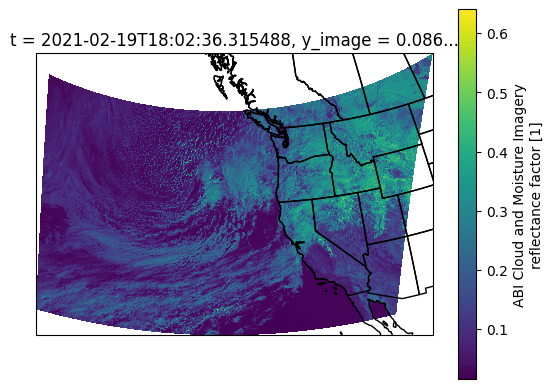

In [69]:
p = subset.CMI_C02.plot(
    x='lon', y='lat', 
    subplot_kws={'projection' : ccrs.Orthographic(-130, 40)},
    transform = ccrs.PlateCarree()
)
p.axes.add_feature(cfeature.COASTLINE)
p.axes.add_feature(cfeature.STATES)

In [76]:
f = fs.open("s3://noaa-goes16/ABI-L2-ACHTF/2024/001/00/OR_ABI-L2-ACHTF-M6_G16_s20240010000205_e20240010009513_c20240010014469.nc")
ds = xr.open_dataset(f) 
ds = calc_latlon(ds)
ds.coords

/var/folders/lj/dkf5g3gd1gn4rs5_nrmhk4fr0000gn/T/ipykernel_58083/2131788073.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Coordinates:
  * y                   (y) float32 22kB 0.1518 0.1518 ... -0.1518 -0.1518
  * x                   (x) float32 22kB -0.1518 -0.1518 ... 0.1518 0.1518
    t                   datetime64[ns] 8B ...
    y_image             float32 4B ...
    x_image             float32 4B ...
    local_zenith_angle  float32 4B ...
    solar_zenith_angle  float32 4B ...
    lat                 (y, x) float32 118MB nan nan nan nan ... nan nan nan nan
    lon                 (y, x) float32 118MB nan nan nan nan ... nan nan nan nan

In [72]:
lats = (30, 55)
lons = (-152, -112)
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds, lats, lons)
subset = ds.sel(x=slice(x1, x2), y=slice(y2, y1))
subset

<xarray.Dataset> Size: 21MB
Dimensions:                                 (y: 972, x: 1334,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
  * y                                       (y) float32 4kB 0.1317 ... 0.07736
  * x                                       (x) float32 5kB -0.1305 ... -0.0558
    t                                       datetime64[ns] 8B ...
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    local_zenith_angle                      float32 4B ...
    solar_zenith_angle                      float32 4B ...
    lat                                     (y, x) float32 5MB nan nan ... 26.78
    lon                                     (y, x) float32 5MB nan ... -96.25
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/24)
    TEMP                                    (y, x) float32 5MB ...
    DQF                                     (y, x) float32 5MB ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                  int32 4B ...
    y_image_bounds                          (number_of_image_bounds) float32 8B ...
    x_image_bounds                          (number_of_image_bounds) float32 8B ...
    ...                                      ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 8B ...
    algorithm_dynamic_input_data_container  int32 4B ...
    processing_parm_version_container       int32 4B ...
    algorithm_product_version_container     int32 4B ...
    percent_uncorrectable_GRB_errors        float32 4B ...
    percent_uncorrectable_L0_errors         float32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2024-01-01T00:14:46.9Z
    time_coverage_start:       2024-01-01T00:00:20.5Z
    time_coverage_end:         2024-01-01T00:09:51.3Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        2321c57b-b4ef-4eec-973c-9c299004ab5a

In [73]:
subset.TEMP

<xarray.DataArray 'TEMP' (y: 972, x: 1334)> Size: 5MB
[1296648 values with dtype=float32]
Coordinates:
  * y                   (y) float32 4kB 0.1317 0.1317 0.1316 ... 0.07742 0.07736
  * x                   (x) float32 5kB -0.1305 -0.1304 ... -0.05586 -0.0558
    t                   datetime64[ns] 8B ...
    y_image             float32 4B ...
    x_image             float32 4B ...
    local_zenith_angle  float32 4B ...
    solar_zenith_angle  float32 4B ...
    lat                 (y, x) float32 5MB nan nan nan nan ... 26.79 26.78 26.78
    lon                 (y, x) float32 5MB nan nan nan ... -96.29 -96.27 -96.25
Attributes:
    long_name:            ABI L2+ Cloud Top Temperature
    standard_name:        air_temperature_at_cloud_top
    valid_range:          [    0 65530]
    units:                K
    resolution:           y: 0.000056 rad x: 0.000056 rad
    grid_mapping:         goes_imager_projection
    cell_methods:         local_zenith_angle: point (good quality pixel produ...
    ancillary_variables:  DQF

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

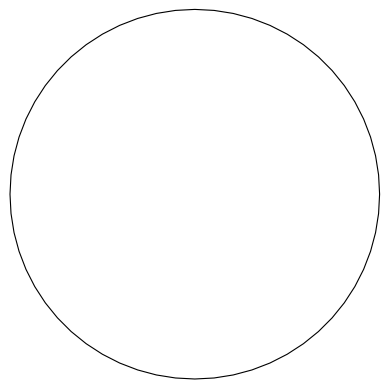

In [74]:
p = subset.TEMP.plot(
    x='lon', y='lat', 
    subplot_kws={'projection' : ccrs.Orthographic(-130, 40)},
    transform = ccrs.PlateCarree()
)
p.axes.add_feature(cfeature.COASTLINE)
p.axes.add_feature(cfeature.STATES)

In [81]:
fs = s3fs.S3FileSystem(anon=True)
#goes 16 data
ftemp = fs.open("s3://noaa-goes16/ABI-L2-ACHTF/2024/001/00/OR_ABI-L2-ACHTF-M6_G16_s20240010000205_e20240010009513_c20240010014469.nc")
#goes 17 cloud top temp
#f = fs.open("s3://noaa-goes17/ABI-L2-ACHTF/2023/001/00/OR_ABI-L2-ACHTF-M6_G17_s20230010000317_e20230010009384_c20230010012096.nc")

#tutorial data
ftut = fs.open("s3://noaa-goes17/ABI-L2-MCMIPC/2021/050/18/OR_ABI-L2-MCMIPC-M6_G17_s20210501801176_e20210501803549_c20210501804089.nc")
dstemp = xr.open_dataset(ftemp) 
dstut = xr.open_dataset(ftut)

In [83]:
print(dstemp)

<xarray.Dataset> Size: 235MB
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
  * y                                       (y) float32 22kB 0.1518 ... -0.1518
  * x                                       (x) float32 22kB -0.1518 ... 0.1518
    t                                       datetime64[ns] 8B ...
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    local_zenith_angle                      float32 4B ...
    solar_zenith_angle                      float32 4B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bou

In [84]:
print(dstut)

<xarray.Dataset> Size: 480MB
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float32 6kB 0.1282 ... 0.04427
  * x                                       (x) float32 10kB -0.06997 ... 0.0...
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_wavelength_C01                     (band) float32 4B ...
    ...                                      ...
    band_id_C11                             (band) int8 1B ...
    band_id_C12                             (band) int8 1B ...
    band_id_C13                             (band) int8 1B ...
    band_id_C14                             (band) int8 1B ...
    band_id_C15         

(-0.5, 5423.5, 5423.5, -0.5)

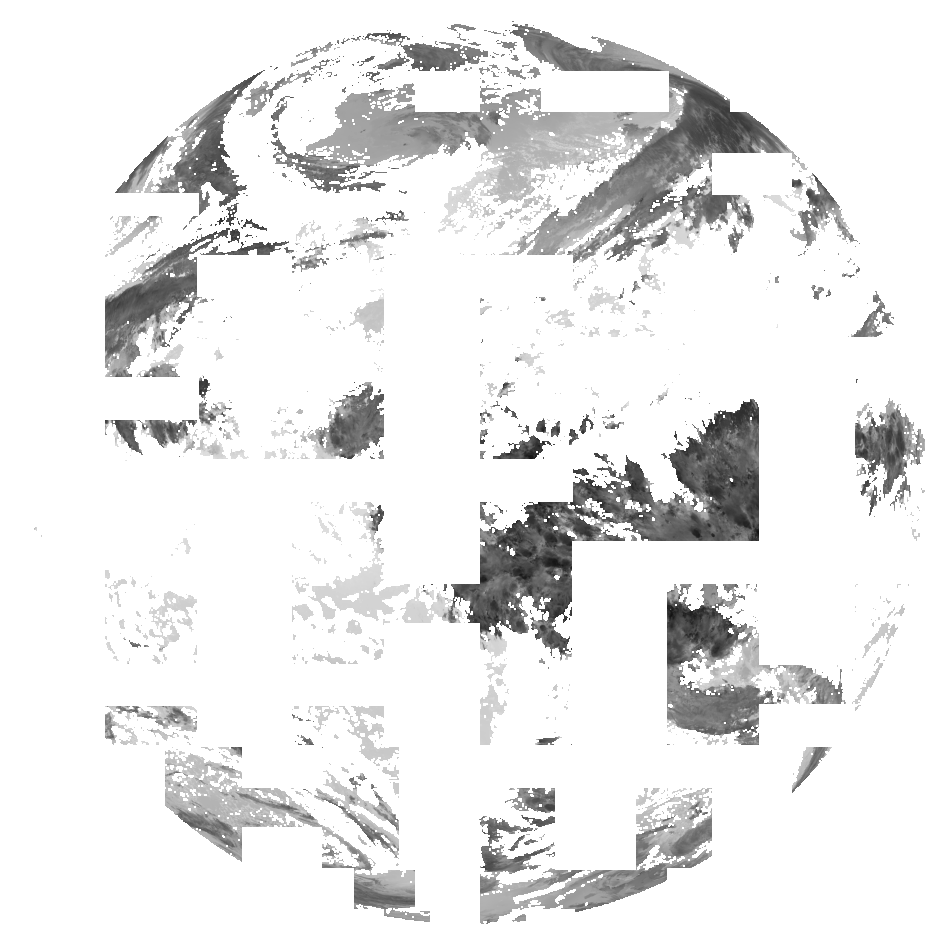

In [86]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(dstemp.TEMP, cmap='gray')
plt.axis('off')
#plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')

(-0.5, 2499.5, 1499.5, -0.5)

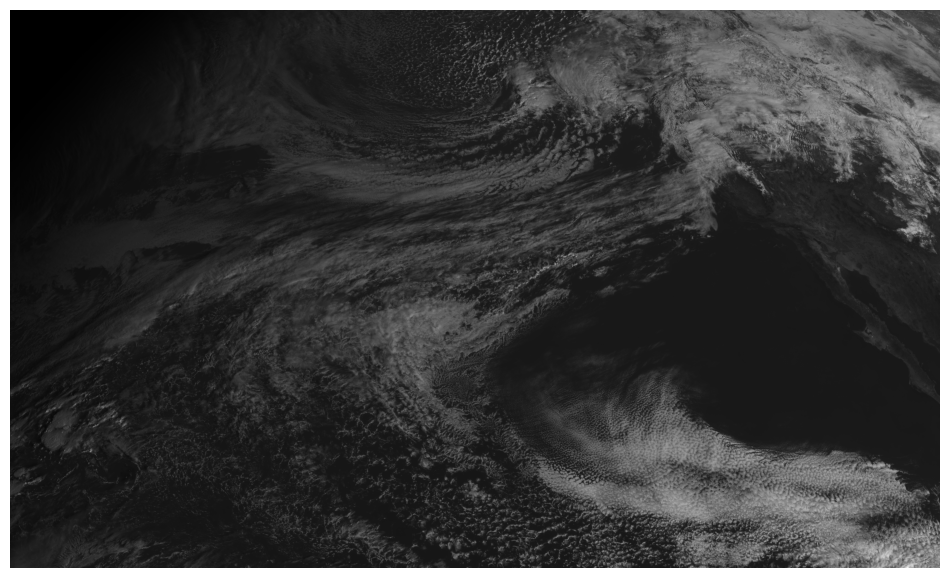

In [87]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(dstut.CMI_C01, cmap='gray')
plt.axis('off')
#plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')